RANDOM CROSS VALIDATION

In [1]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [2]:
import xarray as xr

nh3_nc = xr.load_dataset('../datasets/CAMS-GLOB-ANT_Glb_0.1x0.1_anthro_nh3_v4.2_monthly_lombardia.nc') # Copernicus (0.1°x0.1°)

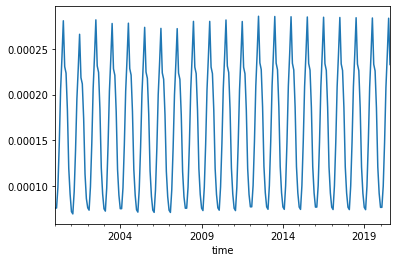

In [3]:
from utils import utils
import matplotlib.pyplot as plt

nh3 = utils.xarray2pandas(nh3_nc.agl, 6, 17).to_period('M')
nh3.plot()
plt.show()

In [4]:
import random

random.seed(0)

def random_training_validation_window(ts, size, validation_size):

    n = len(ts)

    start = random.randint(0, int(n*(1-size)) - validation_size)
    end = start + int(n*size)
    return ts[start:end], ts[end:end+validation_size]

In [5]:
def multiple_forecasts(model, ts, times, refit=False):
    
    predictions = []
    errors = []

    for i in range(len(ts)):
        prediction = model.forecast()
        model = model.append([prediction.values[0]], refit=refit)
        predictions.append(prediction.values[0])
        errors.append(ts.values[i] - prediction.values[0])
    
    return predictions, errors

In [6]:
def autocorr(ts):
    errors = pd.Series(ts)
    n = len(ts)
    data = np.asarray(ts)
    mean = np.mean(data)
    c0 = np.sum((data - mean) ** 2) / float(n)

    def r(h):
        return ((data[:n - h] - mean) * (data[h:] - mean)).sum() / float(n) / c0

    lags = np.arange(n) + 1
    return list(map(r, lags))

In [7]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf
import pandas as pd

def random_cross_validation(ts, order, seasonal_order, times=1, verbose=False):

    aics = []
    bics = []
    rmses = []
    sses = []
    mses = []
    year_autocorrs_in_sample = []
    year_autocorrs_out_of_sample = []
    is_correct = True

    for i in range(times):
        train_months = 180
        validation_months = 12
        train_data, validation_data = random_training_validation_window(nh3, train_months/len(nh3), validation_months)

        assert(len(train_data) == train_months)
        assert(len(validation_data) == validation_months)

        model = ARIMA(endog=train_data, order=order, seasonal_order=seasonal_order).fit()

        aics.append(model.aicc)
        bics.append(model.bic)

        # out of sample
        predictions, errors = multiple_forecasts(model=model, ts=validation_data, times=len(validation_data), refit=False)
        rmse = np.sqrt(np.mean(((predictions - validation_data.values) ** 2)))
        rmses.append(rmse)

        sses.append(model.sse)
        mses.append(model.mse)

        # autocorrelation at lag=12
        year_autocorrs_in_sample.append(autocorr(errors))
        year_autocorrs_out_of_sample.append(autocorr(model.resid)[12])

        is_heteroskedastic = model.test_heteroskedasticity(method=None)[0,1] > 0.05
        is_normal = model.test_normality('jarquebera')[0, 1] > 0.05
        is_correct = is_correct and (is_heteroskedastic and is_normal)

        correct = {'correct': is_correct, 'normality': is_normal, 'heteroskedasticity': is_heteroskedastic}

    return np.mean(rmses), np.mean(aics), np.mean(bics), np.mean(sses),  np.mean(mses), np.mean(np.abs(acf(model.resid))), np.mean                        (np.abs(year_autocorrs_in_sample)), np.mean(np.abs(year_autocorrs_out_of_sample)), correct

In [8]:
# SARIMAX(p,d,q,P,D,Q,s)

import numpy as np
from statsmodels.tsa.stattools import acf

def model_selection(ts, cv_iterations=1, verbose=False):
    
    p_list = [0,1,2,3,4,5,6, [1,2,5,6], [1,6], [1,5,6]]
    q_list = [0,1,2,3,4,5,6]
    P_list = [1]
    Q_list = [0, 1]
    s_list = [12]

    results = {}
    idx = 0

    for p in p_list:
       for q in q_list:
            for P in P_list:
                for Q in Q_list:
                    for s in s_list:
                        model_name = 'SARIMA(p={}, d=0, q={}, P={}, D=0, Q={}, s={})'.format(p, q, P, Q, s)
                        model_idx = idx

                        if verbose: print('{}: {}'.format(model_idx, model_name))
                        
                        rmse, aic, bic, sse, mse, meaacf, yac_in_sample, yac_out_of_sample, correct = random_cross_validation(ts=ts, order=(p,0,q), seasonal_order=(P,0,Q,s), times=cv_iterations)

                        results[model_name] = {
                            'order' : (p,0,q),
                            'seasonal_order' : (P,0,Q,s),
                            'aic' : aic,
                            'bic' : bic,
                            'sse' : sse,
                            'rmse' : rmse,
                            'mse' : mse,
                            'index' : model_idx,
                            'mean_abs_acf': meaacf,
                            'yac_in_sample' : yac_in_sample,
                            'yac_out_of_sample': yac_out_of_sample,
                            'correct': correct     
                            }

                        idx += 1
                    
                    
    return results

In [44]:
results = model_selection(nh3, cv_iterations=1, verbose=True)

0: SARIMA(p=0, d=0, q=0, P=1, D=0, Q=0, s=12)
1: SARIMA(p=0, d=0, q=0, P=1, D=0, Q=1, s=12)
2: SARIMA(p=0, d=0, q=1, P=1, D=0, Q=0, s=12)
3: SARIMA(p=0, d=0, q=1, P=1, D=0, Q=1, s=12)
4: SARIMA(p=0, d=0, q=2, P=1, D=0, Q=0, s=12)
5: SARIMA(p=0, d=0, q=2, P=1, D=0, Q=1, s=12)
6: SARIMA(p=0, d=0, q=3, P=1, D=0, Q=0, s=12)
7: SARIMA(p=0, d=0, q=3, P=1, D=0, Q=1, s=12)
8: SARIMA(p=0, d=0, q=4, P=1, D=0, Q=0, s=12)
9: SARIMA(p=0, d=0, q=4, P=1, D=0, Q=1, s=12)
10: SARIMA(p=0, d=0, q=5, P=1, D=0, Q=0, s=12)
11: SARIMA(p=0, d=0, q=5, P=1, D=0, Q=1, s=12)
12: SARIMA(p=0, d=0, q=6, P=1, D=0, Q=0, s=12)
13: SARIMA(p=0, d=0, q=6, P=1, D=0, Q=1, s=12)
14: SARIMA(p=1, d=0, q=0, P=1, D=0, Q=0, s=12)
15: SARIMA(p=1, d=0, q=0, P=1, D=0, Q=1, s=12)
16: SARIMA(p=1, d=0, q=1, P=1, D=0, Q=0, s=12)
17: SARIMA(p=1, d=0, q=1, P=1, D=0, Q=1, s=12)
18: SARIMA(p=1, d=0, q=2, P=1, D=0, Q=0, s=12)
19: SARIMA(p=1, d=0, q=2, P=1, D=0, Q=1, s=12)
20: SARIMA(p=1, d=0, q=3, P=1, D=0, Q=0, s=12)
21: SARIMA(p=1, d=0, q=

In [46]:
filtered_results = {k: v for k, v in results.items() if v['correct'] is True}

0

In [47]:
aics = [v['aic'] for k, v in results.items()]
bics = [v['bic'] for k, v in results.items()]
rmses = [v['rmse'] for k, v in results.items()]
sses = [v['sse'] for k, v in results.items()]
mses = [v['mse'] for k, v in results.items()]
maacf = [v['mean_abs_acf'] for k, v in results.items()]
yac_in_sample = [v['yac_in_sample'] for k, v in results.items()]
yac_out_of_sample = [v['yac_out_of_sample'] for k, v in results.items()]

In [48]:
def tick(order, seasonal_order):
    p, d, q = order
    P, D, Q, s = seasonal_order
    return str((p,q,P,Q))

ticks = [tick(v['order'], v['seasonal_order']) for k, v in sorted(results.items(), key=lambda item: item[1]['index'])]

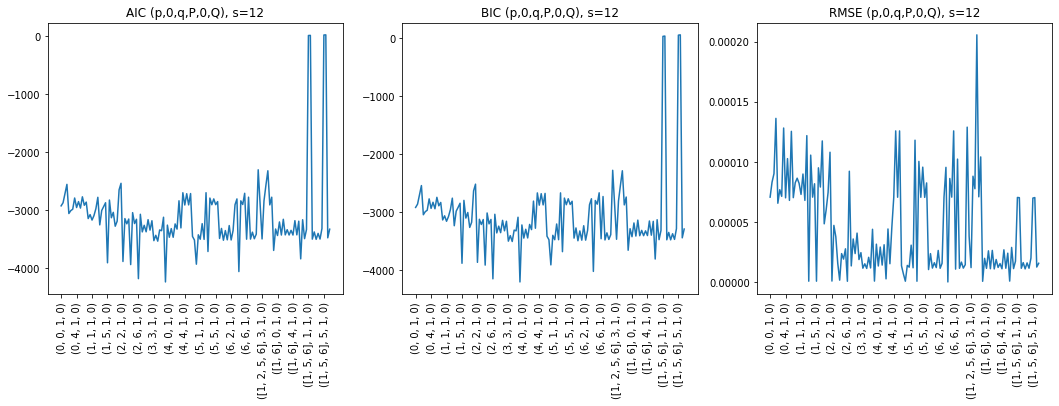

In [49]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
indices = np.arange(0, len(results), 8)

axs[0].plot(aics)
axs[0].set_title('AIC (p,0,q,P,0,Q), s=12')
axs[0].set_xticks(indices)
axs[0].set_xticklabels(np.array(ticks)[indices], rotation=90)

axs[1].plot(bics)
axs[1].set_title('BIC (p,0,q,P,0,Q), s=12')
axs[1].set_xticks(indices)
axs[1].set_xticklabels(np.array(ticks)[indices], rotation=90)

axs[2].plot(rmses)
axs[2].set_title('RMSE (p,0,q,P,0,Q), s=12')
axs[2].set_xticks(indices)
axs[2].set_xticklabels(np.array(ticks)[indices], rotation=90)

plt.show()

In [50]:
print('min AIC: {}, min BIC {}, min RMSE {}'.format(np.argmin(aics), np.argmin(bics), np.argmin(rmses)))

min AIC: 54, min BIC 54, min RMSE 92


In [51]:
min_aic_model = [v for k,v in results.items() if v['aic'] == np.min(aics)][0]
min_aic_model

{'order': (3, 0, 6),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -4242.256552975614,
 'bic': -4205.809334237985,
 'sse': 6.498709281170577e-09,
 'rmse': 8.656856120470645e-07,
 'mse': 3.610394045094765e-11,
 'index': 54,
 'mean_abs_acf': 0.07373529682793328,
 'yac_in_sample': 0.0596303756246932,
 'yac_out_of_sample': 0.031347339690098765,
 'correct': False}

In [15]:
min_bic_model = [v for k,v in results.items() if v['bic'] == np.min(bics)][0]
min_bic_model

{'order': (3, 0, 0),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -4238.457681258066,
 'bic': -4219.785489285673,
 'sse': 7.430362020489099e-09,
 'rmse': 1.066592501109961e-06,
 'mse': 4.127978900271722e-11,
 'index': 42,
 'mean_abs_acf': 0.06694859471289857,
 'yac_in_sample': 0.25751979863964847,
 'yac_out_of_sample': 0.011072016476923834}

In [16]:
min_rmse_model = [v for k,v in results.items() if v['rmse'] == np.min(rmses)][0]
min_rmse_model

{'order': (4, 0, 5),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -3838.823460071476,
 'bic': -3802.3762413338472,
 'sse': 6.036789014280872e-08,
 'rmse': 1.6235864745373289e-07,
 'mse': 3.3537716746004845e-10,
 'index': 66,
 'mean_abs_acf': 0.12790052119447748,
 'yac_in_sample': 0.2832204578631062,
 'yac_out_of_sample': 0.07460781098660588}

In [17]:
min_sse_model = [v for k,v in results.items() if v['sse'] == np.min(sses)][0]
min_sse_model

{'order': ([1, 2, 5, 6], 0, 1),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -3989.4373382879826,
 'bic': -3964.735788744019,
 'sse': 6.857467782645687e-09,
 'rmse': 8.804432904354243e-07,
 'mse': 3.8097043236920485e-11,
 'index': 100,
 'mean_abs_acf': 0.08374886741579807,
 'yac_in_sample': 0.05490624961700322,
 'yac_out_of_sample': 0.045143107252920374}

In [18]:
min_mse_model = [v for k,v in results.items() if v['mse'] == np.min(mses)][0]
min_mse_model

{'order': ([1, 2, 5, 6], 0, 1),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -3989.4373382879826,
 'bic': -3964.735788744019,
 'sse': 6.857467782645687e-09,
 'rmse': 8.804432904354243e-07,
 'mse': 3.8097043236920485e-11,
 'index': 100,
 'mean_abs_acf': 0.08374886741579807,
 'yac_in_sample': 0.05490624961700322,
 'yac_out_of_sample': 0.045143107252920374}

In [19]:
min_abs_acf_model = [v for k,v in results.items() if v['mean_abs_acf'] == np.min(maacf)][0]
min_abs_acf_model

{'order': (4, 0, 2),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -3584.990069902792,
 'bic': -3557.312281774192,
 'sse': 1.0854941777432796e-08,
 'rmse': 8.170093098608336e-07,
 'mse': 6.030523209684886e-11,
 'index': 60,
 'mean_abs_acf': 0.060235941743051864,
 'yac_in_sample': 0.05760592238621512,
 'yac_out_of_sample': 0.005025923901578942}

In [20]:
min_yac_in_sample_model = [v for k,v in results.items() if v['yac_in_sample'] == np.min(yac_in_sample)][0]
min_yac_in_sample_model

{'order': (1, 0, 0),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -4136.8030407691585,
 'bic': -4124.25978479417,
 'sse': 1.8739849404776607e-08,
 'rmse': 7.899186482122576e-07,
 'mse': 1.0411027447098115e-10,
 'index': 14,
 'mean_abs_acf': 0.09605903080575592,
 'yac_in_sample': 0.04970982202326166,
 'yac_out_of_sample': 0.0020276934797921007}

In [21]:
min_yac_out_of_sample_model = [v for k,v in results.items() if v['yac_out_of_sample'] == np.min(yac_out_of_sample)][0]
min_yac_out_of_sample_model

{'order': (6, 0, 6),
 'seasonal_order': (1, 0, 1, 12),
 'aic': -3247.7123291351218,
 'bic': -3199.962442833762,
 'sse': 1.1597789286017147e-07,
 'rmse': 2.705380260723596e-05,
 'mse': 6.443216270009526e-10,
 'index': 97,
 'mean_abs_acf': 0.1893306601629425,
 'yac_in_sample': 0.11995323685176364,
 'yac_out_of_sample': 0.0012339136830113284}

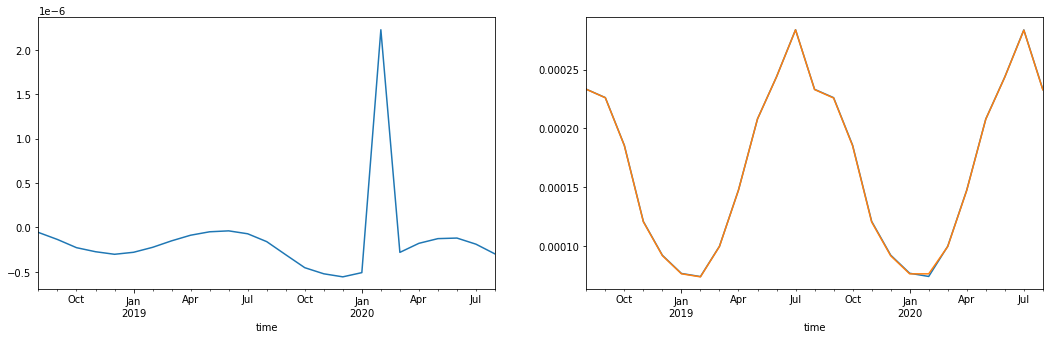

In [22]:
import pandas as pd

train_data, validation_data = utils.ts_train_test_split(nh3, .9)
validation_data = validation_data

best_model = ARIMA(train_data, order=min_aic_model['order'], seasonal_order=min_aic_model['seasonal_order']).fit()
predictions, errors = multiple_forecasts(model=best_model, ts=validation_data, times=len(validation_data), refit=False)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,5))

pd.Series(errors, index=validation_data.index).plot(ax=axs[0])

pd.Series(predictions, index=validation_data.index).plot(ax=axs[1])
validation_data.plot(ax=axs[1])
plt.show()

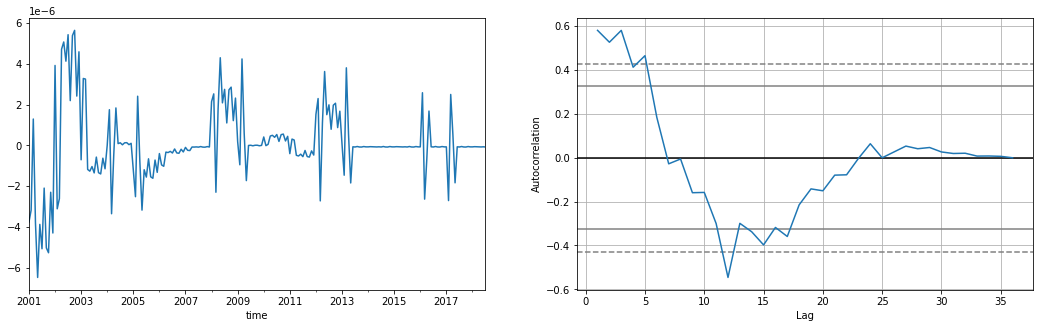

In [23]:
from pandas.plotting import autocorrelation_plot

errors = best_model.resid

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,5))

pd.Series(errors[12:]).plot(ax=axs[0])
autocorrelation_plot(errors[12:48], ax=axs[1])
plt.show()

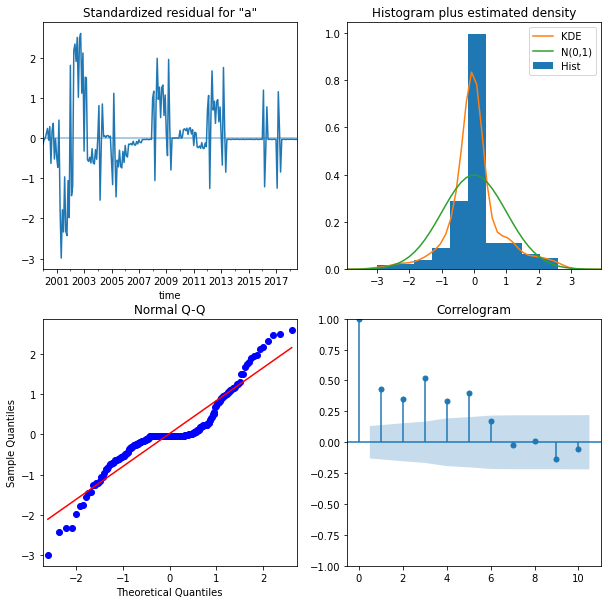

In [24]:
best_model.plot_diagnostics(figsize=(10,10))
plt.show()

Excluding the first 12 months due to seasonality

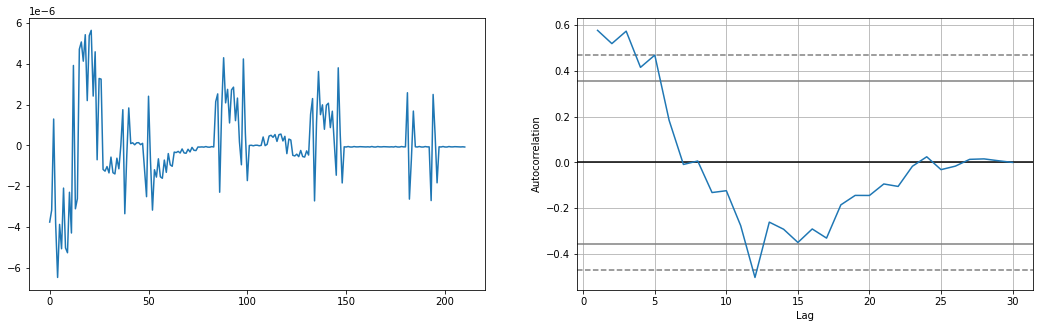

In [25]:
predictions = best_model.predict(start=train_data.index[12], end=train_data.index[-1])

errors = train_data[12:].values - predictions.values

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,5))

pd.Series(errors).plot(ax=axs[0])
autocorrelation_plot(errors[:30], ax=axs[1])
plt.show()

In [26]:
#  null hypothesis is of no heteroskedasticity

result = best_model.test_heteroskedasticity(method=None)
if result[0, 1] < 0.05: print('Eteroschedastici')
result

Eteroschedastici


array([[1.48031824e-01, 1.71241468e-14]])

In [27]:
best_model.test_normality('jarquebera')

array([[5.86588139e+01, 1.82978646e-13, 2.14941816e-01, 5.47553151e+00]])

In [28]:
print(best_model.pvalues)

const       0.177120
ar.L1       0.000000
ar.L2       0.000000
ar.L3       0.000000
ar.S.L12    0.000000
sigma2      0.971416
dtype: float64


In [29]:
best_model.params

const       1.634133e-04
ar.L1       9.706747e-01
ar.L2       2.305370e-01
ar.L3      -6.654999e-01
ar.S.L12    9.994619e-01
sigma2      4.696497e-12
dtype: float64

In [30]:
best_model.test_serial_correlation('boxpierce', lags=12)[0][1]

array([1.08630538e-10, 9.61435257e-16, 4.88359447e-28, 1.70705102e-32,
       3.49416288e-39, 8.66462230e-40, 4.92435179e-39, 2.68524099e-38,
       1.92612638e-38, 6.95302563e-38, 2.63885741e-38, 3.84239745e-49])

In [31]:
from statsmodels.stats.diagnostic import acorr_ljungbox

acorr_ljungbox(errors, model_df=len(best_model.param_names)-1)[1]

array([           nan,            nan,            nan,            nan,
                  nan, 4.38508449e-45, 7.78209723e-44, 7.85822734e-43,
       1.69637938e-42, 1.08094029e-41, 5.68158003e-42, 1.35892925e-52,
       9.74807644e-54, 5.12533019e-54, 1.67336933e-57, 4.84377532e-59,
       5.14611391e-61, 2.72880492e-61, 1.09831128e-60, 3.05428208e-60,
       1.41090917e-59, 6.02167732e-59, 2.67850863e-58, 2.51893426e-58,
       5.08048650e-58, 1.87339975e-57, 6.00986164e-57, 2.30167636e-56,
       8.66877064e-56, 3.26402373e-55, 3.42637681e-55, 6.33598035e-55,
       4.55387385e-55, 1.26754651e-54, 3.61261620e-54, 2.69538348e-57,
       1.57129555e-57, 5.17009537e-57, 4.22053190e-57, 8.46520510e-57])

In [39]:
min_aic = np.min(aics)
candidate_models = [v for k,v in results.items() if v['aic'] < min_aic*0.9 ]

In [40]:
aics = [v['aic'] for v in candidate_models]
bics = [v['bic'] for v in candidate_models]
rmses = [v['rmse'] for v in candidate_models]
sses = [v['sse'] for v in candidate_models]
mses = [v['mse'] for v in candidate_models]
maacf = [v['mean_abs_acf'] for v in candidate_models]
yac_in_sample = [v['yac_in_sample'] for v in candidate_models]
yac_out_of_sample = [v['yac_out_of_sample'] for v in candidate_models]

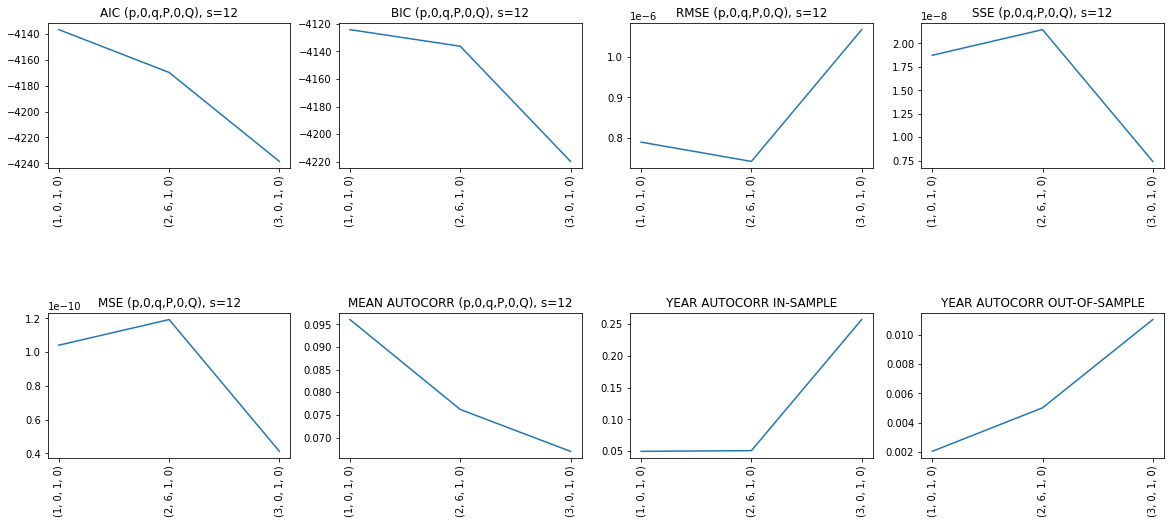

In [41]:
ticks = [tick(v['order'], v['seasonal_order']) for v in candidate_models]

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20,8))
indices = np.arange(0, len(candidate_models), 1)

fig.subplots_adjust(hspace=1)

axs[0,0].plot(aics)
axs[0,0].set_title('AIC (p,0,q,P,0,Q), s=12')
axs[0,0].set_xticks(indices)
axs[0,0].set_xticklabels(np.array(ticks)[indices], rotation=90)

axs[0,1].plot(bics)
axs[0,1].set_title('BIC (p,0,q,P,0,Q), s=12')
axs[0,1].set_xticks(indices)
axs[0,1].set_xticklabels(np.array(ticks)[indices], rotation=90)

axs[0,2].plot(rmses)
axs[0,2].set_title('RMSE (p,0,q,P,0,Q), s=12')
axs[0,2].set_xticks(indices)
axs[0,2].set_xticklabels(np.array(ticks)[indices], rotation=90)

axs[0,3].plot(sses)
axs[0,3].set_title('SSE (p,0,q,P,0,Q), s=12')
axs[0,3].set_xticks(indices)
axs[0,3].set_xticklabels(np.array(ticks)[indices], rotation=90)

axs[1,0].plot(mses)
axs[1,0].set_title('MSE (p,0,q,P,0,Q), s=12')
axs[1,0].set_xticks(indices)
axs[1,0].set_xticklabels(np.array(ticks)[indices], rotation=90)

axs[1,1].plot(maacf)
axs[1,1].set_title('MEAN AUTOCORR (p,0,q,P,0,Q), s=12')
axs[1,1].set_xticks(indices)
axs[1,1].set_xticklabels(np.array(ticks)[indices], rotation=90)

axs[1,2].plot(yac_in_sample)
axs[1,2].set_title('YEAR AUTOCORR IN-SAMPLE')
axs[1,2].set_xticks(indices)
axs[1,2].set_xticklabels(np.array(ticks)[indices], rotation=90)

axs[1,3].plot(yac_out_of_sample)
axs[1,3].set_title('YEAR AUTOCORR OUT-OF-SAMPLE')
axs[1,3].set_xticks(indices)
axs[1,3].set_xticklabels(np.array(ticks)[indices], rotation=90)


plt.show()

In [58]:
best_model.test_normality(method='jarquebera')

array([[5.86588139e+01, 1.82978646e-13, 2.14941816e-01, 5.47553151e+00]])